# Model Output Analysis

Now that we have run MATILDA so many times we finally want to have a look at the **results**. In this notebook we will...

1. ...create **custom data frames** containing individual output variables from all ensemble members,

2. ...**plot the ensemble mean** of these variables with a 90% confidence interval,

3. ...and create an **interactive application** to explore the results.

## Custom dataframes

First, we read our paths from the `config.ini` again and use some helper functions to convert our stored MATILDA output back into a dictionary.

In [1]:
from tools.helpers import pickle_to_dict, parquet_to_dict
import configparser

# read output directory from config.ini file
config = configparser.ConfigParser()
config.read('config.ini')
dir_output = config['FILE_SETTINGS']['DIR_OUTPUT']

print("Importing MATILDA scenarios...")
# For size:
matilda_scenarios = parquet_to_dict(f"{dir_output}cmip6/adjusted/matilda_scenarios_parquet")

# For speed:
# matilda_scenarios = pickle_to_dict(f"{dir_output}cmip6/adjusted/matilda_scenarios.pickle")

Reading parquet files: 100%|██████████████████████| 2/2 [00:02<00:00,  1.29s/it]


At the moment, the structure of the ensemble output is as follows:

To analyze all projections of a single variable, we need a function to rearrange the data. The `custom_df_matilda()` function returns a dataframe with all ensemble members for a given variable and scenario resampled to a desired frequency, e.g. **the total annual runoff under SSP 2**.

In [2]:
import pandas as pd

def custom_df_matilda(dic, scenario, var, resample_freq=None):
    """
    Takes a dictionary of model outputs and returns a combined dataframe of a specific variable for a given scenario.
    Parameters
    -------
    dic : dict
        A nested dictionary of model outputs.
        The outer keys are scenario names and the inner keys are model names.
        The corresponding values are dictionaries containing two keys:
        'model_output' (DataFrame): containing model outputs for a given scenario and model
        'glacier_rescaling' (DataFrame): containing glacier properties for a given scenario and model
    scenario : str
        The name of the scenario to select from the dictionary.
    var : str
        The name of the variable to extract from the model output DataFrame.
    resample_freq : str, optional
        The frequency of the resulting time series data.
        Defaults to None (i.e. no resampling).
        If provided, should be in pandas resample frequency string format.
    Returns
    -------
    pandas.DataFrame
        A DataFrame containing the combined data of the specified variable for the selected scenario
        and models. The DataFrame is indexed by the time steps of the original models.
        The columns are the names of the models in the selected scenario.
    Raises
    -------
    ValueError
        If the provided  var  string is not one of the following: ['avg_temp_catchment', 'avg_temp_glaciers',
        'evap_off_glaciers', 'prec_off_glaciers', 'prec_on_glaciers', 'rain_off_glaciers', 'snow_off_glaciers',
        'rain_on_glaciers', 'snow_on_glaciers', 'snowpack_off_glaciers', 'soil_moisture', 'upper_groundwater',
        'lower_groundwater', 'melt_off_glaciers', 'melt_on_glaciers', 'ice_melt_on_glaciers', 'snow_melt_on_glaciers',
        'refreezing_ice', 'refreezing_snow', 'total_refreezing', 'SMB', 'actual_evaporation', 'total_precipitation',
        'total_melt', 'runoff_without_glaciers', 'runoff_from_glaciers', 'total_runoff', 'glacier_area',
        'glacier_elev', 'smb_water_year', 'smb_scaled', 'smb_scaled_capped', 'smb_scaled_capped_cum', 'surplus']
    """
    out1_cols = ['avg_temp_catchment', 'avg_temp_glaciers', 'evap_off_glaciers',
                 'prec_off_glaciers', 'prec_on_glaciers', 'rain_off_glaciers',
                 'snow_off_glaciers', 'rain_on_glaciers', 'snow_on_glaciers',
                 'snowpack_off_glaciers', 'soil_moisture', 'upper_groundwater',
                 'lower_groundwater', 'melt_off_glaciers', 'melt_on_glaciers',
                 'ice_melt_on_glaciers', 'snow_melt_on_glaciers', 'refreezing_ice',
                 'refreezing_snow', 'total_refreezing', 'SMB', 'actual_evaporation',
                 'total_precipitation', 'total_melt', 'runoff_without_glaciers',
                 'runoff_from_glaciers', 'total_runoff']

    out2_cols = ['glacier_area', 'glacier_elev', 'smb_water_year',
                 'smb_scaled', 'smb_scaled_capped', 'smb_scaled_capped_cum',
                 'surplus']

    if var in out1_cols:
        output_df = 'model_output'
    elif var in out2_cols:
        output_df = 'glacier_rescaling'
    else:
        raise ValueError("var needs to be one of the following strings: " +
                         str([i for i in [out1_cols, out2_cols]]))

    # Create an empty list to store the dataframes
    dfs = []
    # Loop over the models in the selected scenario
    for model in dic[scenario].keys():
        # Get the dataframe for the current model
        df = dic[scenario][model][output_df]
        # Append the dataframe to the list of dataframes
        dfs.append(df[var])
    # Concatenate the dataframes into a single dataframe
    combined_df = pd.concat(dfs, axis=1)
    # Set the column names of the combined dataframe to the model names
    combined_df.columns = dic[scenario].keys()
    # Resample time series
    if resample_freq is not None:
        if output_df == 'glacier_rescaling':
            if var in ['glacier_area', 'glacier_elev']:
                combined_df = combined_df.resample(resample_freq).mean()
            else:
                combined_df = combined_df.resample(resample_freq).sum()
        else:
            if var in ['avg_temp_catchment', 'avg_temp_glaciers']:
                combined_df = combined_df.resample(resample_freq).mean()
            else:
                combined_df = combined_df.resample(resample_freq).sum()

    return combined_df


# Application example:
print('Total Annual Runoff Projections across Ensemble Members:\n')
print(custom_df_matilda(matilda_scenarios, 'SSP2', 'total_runoff', 'Y'))

Total Annual Runoff Projections across Ensemble Members:

              ACCESS-CM2  ACCESS-ESM1-5   BCC-CSM2-MR         CESM2  \
TIMESTAMP                                                             
1981-12-31  36191.555090   36361.686211  41733.288180  35275.399407   
1982-12-31  33638.013134   37336.465514  36503.298057  33911.207308   
1983-12-31  33492.549952   31100.695266  36865.828927  36067.861352   
1984-12-31  33082.241074   34764.000940  33274.038163  37451.923849   
1985-12-31  32485.508128   35921.395008  34735.359621  37392.283700   
...                  ...            ...           ...           ...   
2096-12-31  43772.064403   42951.919026  48671.071462  42812.155923   
2097-12-31  47175.041032   41933.448192  49183.562977  44254.667754   
2098-12-31  48410.493808   45843.718650  48805.403169  42464.557905   
2099-12-31  46374.618831   45587.795917  49972.026561  43872.026253   
2100-12-31  48098.762879   41227.079318  48408.710083  44730.886621   

             CESM2

## Plot ensemble mean with confidence interval

Showing 31 curves in one figure gets confusing. A standard way to visualize ensemble data is to plot **the mean** (or median) **across all ensemble members with a confidence interval**. We choose a 95% confidence interval, meaning that based on this sample of 31 climate models, there is a 95% probability that the "true" mean lies within this interval.

[<img src="https://miro.medium.com/max/3840/1*qSCzTfliGMCcPfIQcGIAJw.jpeg" width="70%"/>](https://miro.medium.com/max/3840/1*qSCzTfliGMCcPfIQcGIAJw.jpeg)

&copy; *[Stefanie Owens @ Medium.com](https://medium.com/design-ibm/who-needs-backup-dancers-when-you-can-have-confidence-intervals-485f9464c06f)*

In [3]:
def confidence_interval(df):
    """
    Calculate the mean and 95% confidence interval for each row in a dataframe.
    Parameters:
    -----------
        df (pandas.DataFrame): The input dataframe.
    Returns:
    --------
        pandas.DataFrame: A dataframe with the mean and confidence intervals for each row.
    """
    mean = df.mean(axis=1)
    std = df.std(axis=1)
    count = df.count(axis=1)
    ci = 1.96 * std / np.sqrt(count)
    ci_lower = mean - ci
    ci_upper = mean + ci
    df_ci = pd.DataFrame({'mean': mean, 'ci_lower': ci_lower, 'ci_upper': ci_upper})
    return df_ci



We are going to use the `plotly` library again to create interactive plots. For now, let's plot *total discharge* over all ensemble members. You can change the variables and resampling frequency in the example at will.

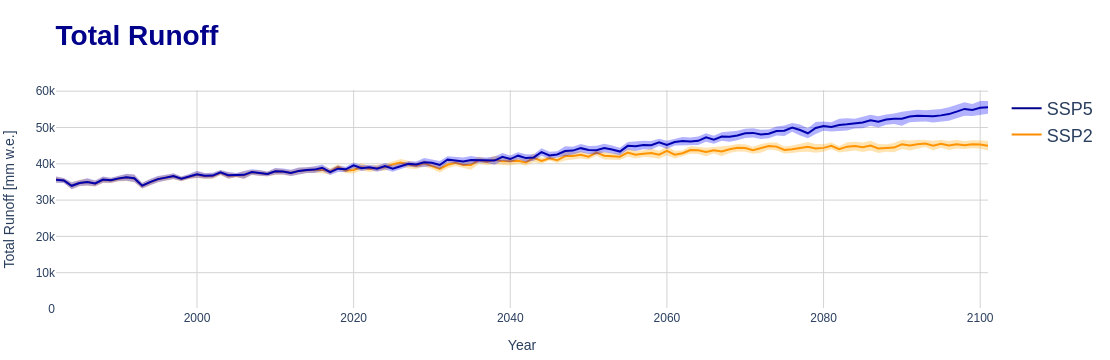

In [4]:
import plotly.graph_objects as go
import numpy as np
from tools.helpers import matilda_vars

def plot_ci_matilda(var, dic=matilda_scenarios, resample_freq='Y', show=False):
    """
    A function to plot multi-model mean and confidence intervals of a given variable for two different scenarios.
    Parameters:
    -----------
    var: str
        The variable to plot.
    dic: dict, optional (default=matilda_scenarios)
        A dictionary containing the scenarios as keys and the dataframes as values.
    resample_freq: str, optional (default='Y')
        The resampling frequency to apply to the data.
    show: bool, optional (default=False)
        Whether to show the resulting plot or not.
    Returns:
    --------
    go.Figure
        A plotly figure object containing the mean and confidence intervals for the given variable in the two selected scenarios.
    """

    if var is None:
        var = 'total_runoff'       # Default if nothing selected

    # SSP2
    df1 = custom_df_matilda(dic, scenario='SSP2', var=var, resample_freq=resample_freq)
    df1_ci = confidence_interval(df1)
    # SSP5
    df2 = custom_df_matilda(dic, scenario='SSP5', var=var, resample_freq=resample_freq)
    df2_ci = confidence_interval(df2)

    fig = go.Figure([
        # SSP2
        go.Scatter(
            name='SSP2',
            x=df1_ci.index,
            y=round(df1_ci['mean'], 2),
            mode='lines',
            line=dict(color='darkorange'),
        ),
        go.Scatter(
            name='95% CI Upper',
            x=df1_ci.index,
            y=round(df1_ci['ci_upper'], 2),
            mode='lines',
            marker=dict(color='#444'),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='95% CI Lower',
            x=df1_ci.index,
            y=round(df1_ci['ci_lower'], 2),
            marker=dict(color='#444'),
            line=dict(width=0),
            mode='lines',
            fillcolor='rgba(255, 165, 0, 0.3)',
            fill='tonexty',
            showlegend=False
        ),

        # SSP5
        go.Scatter(
            name='SSP5',
            x=df2_ci.index,
            y=round(df2_ci['mean'], 2),
            mode='lines',
            line=dict(color='darkblue'),
        ),
        go.Scatter(
            name='95% CI Upper',
            x=df2_ci.index,
            y=round(df2_ci['ci_upper'], 2),
            mode='lines',
            marker=dict(color='#444'),
            line=dict(width=0),
            showlegend=False
        ),
        go.Scatter(
            name='95% CI Lower',
            x=df2_ci.index,
            y=round(df2_ci['ci_lower'], 2),
            marker=dict(color='#444'),
            line=dict(width=0),
            mode='lines',
            fillcolor='rgba(0, 0, 255, 0.3)',
            fill='tonexty',
            showlegend=False
        )
    ])
    fig.update_layout(
        xaxis_title='Year',
        yaxis_title=matilda_vars[var][0] + ' [' + matilda_vars[var][1] + ']',
        title={'text': '<b>' + matilda_vars[var][0] + '</b>', 'font': {'size': 28, 'color': 'darkblue', 'family': 'Arial'}},
        legend={'font': {'size': 18, 'family': 'Arial'}},
        hovermode='x',
        plot_bgcolor='rgba(255, 255, 255, 1)',  # Set the background color to white
        margin=dict(l=10, r=10, t=90, b=10),  # Adjust the margins to remove space around the plot
        xaxis=dict(gridcolor='lightgrey'),  # set the grid color of x-axis to lightgrey
        yaxis=dict(gridcolor='lightgrey'),  # set the grid color of y-axis to lightgrey
    )
    fig.update_yaxes(rangemode='tozero')

    # show figure
    if show:
        fig.show()
    else:
        return fig



# Application example

plot_ci_matilda('total_runoff', resample_freq='Y', show=True)

## Interactive plotting application 

To make the full dataset more accessible, we can integrate these figures into an **interactive application** using [`ploty.Dash`](https://dash.plotly.com/). This launches a `Dash` server that updates the figures as you select variables and frequencies in the **dropdown menus**. To compare time series, you can align multiple figures in the same application. The demo application aligns three figures showing *total runoff, total precipitation* and *runoff_from_glaciers* by default directly in the output cell. If you want to display the complete application in a separate Jupyter tab, set `display_mode='tab'`.

In [ ]:
import dash
from jupyter_dash import JupyterDash
import plotly.io as pio
pio.renderers.default = "browser"
JupyterDash.infer_jupyter_proxy_config()
#app = dash.Dash()
app = JupyterDash(__name__)
server = app.server


def matilda_dash(fig_count=4,
                 default_vars=['total_runoff', 'total_precipitation', 'runoff_from_glaciers', 'glacier_area'],
                 display_mode='inLine'):
    
    # If number of default variables does not match the number of figures use variables in default order
    if fig_count != len(default_vars):
        default_vars = list(matilda_vars.keys())

    
    # Create separate callback functions for each dropdown menu and graph combination
    for i in range(fig_count):
        @app.callback(
            dash.dependencies.Output(f'line-plot-{i}', 'figure'),
            dash.dependencies.Input(f'arg-dropdown-{i}', 'value'),
            dash.dependencies.Input(f'freq-dropdown-{i}', 'value')
        )
        def update_figure(selected_arg, selected_freq, i=i):
            fig = plot_ci_matilda(selected_arg, resample_freq=selected_freq)
            return fig

    # Define the dropdown menus and figures
    dropdowns_and_figures = []
    for i in range(fig_count):
        arg_dropdown = dash.dcc.Dropdown(
            id=f'arg-dropdown-{i}',
            options=[{'label': matilda_vars[var][0], 'value': var} for var in matilda_vars.keys()],
            value=default_vars[i],
            clearable=False,
            style={'width': '400px', 'fontFamily': 'Arial', 'fontSize': 15}
        )
        freq_dropdown = dash.dcc.Dropdown(
            id=f'freq-dropdown-{i}',
            options=[{'label': freq, 'value': freq} for freq in ['M', 'Y', '10Y']],
            value='Y',
            clearable=False,
            style={'width': '100px'}
        )
        dropdowns_and_figures.append(
            dash.html.Div([
                dash.html.Div([
                    dash.html.Label("Variable:"),
                    arg_dropdown,
                ], style={'display': 'inline-block', 'margin-right': '30px'}),
                dash.html.Div([
                    dash.html.Label("Frequency:"),
                    freq_dropdown,
                ], style={'display': 'inline-block'}),
                dash.dcc.Graph(id=f'line-plot-{i}'),
            ])
        )
    # Combine the dropdown menus and figures into a single layout
    app.layout = dash.html.Div(dropdowns_and_figures)

    if display_mode == 'inLine':
        # Run the app directly in the output cell
        app.run_server(mode="inline")

    elif display_mode == 'tab':
        # Run the app in a new Jupyter Tab
        app.run_server(mode="jupyterlab")
    
    else:
        raise ValueError("Invalid property specified for 'display_mode'. Choose either 'inLine' or 'tab'")
        

        
        
# Application example:
matilda_dash(fig_count=3,
             default_vars=['total_runoff', 'total_precipitation', 'runoff_from_glaciers'],
             display_mode='inLine')

![Dash Example](images/nb6_plotly.gif)